## Hybrid Search RAG

* Data - Chunk - Embeddings (Dense and Sparse) - Vector Database
* Instead of using Langchain directly, we will use Qdrant or vector database.

In [ ]:
!pip install langchain langchain-community
!pip install pypdfium2

In [ ]:
!pip install fastembed # from fastembed import TextEmbeddings, SparseTextEmbedding
!pip install qdrant-client
!pip install langgraph langchain
!pip install langchain-google-genai
# hybrid search - collection_name

In [ ]:
from langchain_community.document_loaders import WebBaseLoader,PyPDFium2Loader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [ ]:
urls = [
    "https://atyantik.com/",
    "https://atyantik.com/about-us/",
    "https://atyantik.com/software-development-company/",
    "https://atyantik.com/saas-development/",
]

In [ ]:
loader = WebBaseLoader(urls)
# loader = PyPDF(/content/drive/MyDrive/Resume/Tarun_Resume.pdf)
documents = loader.load()

In [ ]:
splitter = RecursiveCharacterTextSplitter(chunk_size=2048, chunk_overlap=0)
chunks = splitter.split_documents(documents)

In [ ]:
len(chunks)

45

## Vector Database

In [ ]:
from qdrant_client import QdrantClient,models
from qdrant_client.http.models import Distance, VectorParams, SparseVectorParams # create collection
# client.create_collection # vector config and sparse config
from qdrant_client.models import PointStruct
from fastembed import TextEmbedding, SparseTextEmbedding
# search logic (Points)
# vectorParams - Dense
# Distance - Cosine
# SparseParams: TFIDF, BM25 and BM42
import os
from google.colab import userdata

1. Define the client
2. Create collection: Configure parameters
3. Add documents. Loop it over the entire chunks with the embeddings.
4. Search (Points)
5. Node: LangGraph node for the retrieval.

In [ ]:
url = userdata.get("QDRANT_URL")
api_key = userdata.get("QDRANT_API_KEY")

In [ ]:
client = QdrantClient(
    url = url,
    api_key=api_key,
)

In [ ]:
collection_name = "hybrid"

## Load the embedding model

In [ ]:
dense_embedding_model = TextEmbedding(model_name="jinaai/jina-embeddings-v2-base-en")

In [ ]:
sparse_embedding_model = SparseTextEmbedding("Qdrant/BM25")

In [ ]:
client.create_collection(
    collection_name = collection_name,
    vectors_config = {
        "dense": VectorParams(
            size = 768,
            distance = Distance.COSINE,
            on_disk=True
        )
    },
    sparse_vectors_config = {
        "sparse": SparseVectorParams(
            modifier=models.Modifier.IDF
        )
    },
    quantization_config=models.BinaryQuantization(
        binary = models.BinaryQuantizationConfig(always_ram=False)
    )
)

True

## Points - Add your data. Upsert: Updating it into the collection

In [ ]:
dummy_eles = ['Naruto','OP','DBZ','Bleach']

In [ ]:
for idx, ele in enumerate(dummy_eles):
  print(ele)

Naruto
OP
DBZ
Bleach


enumerate - looping but with an index

client
  - payload
  - vector (embeddings)
  - id - unique

In [ ]:
dense_embeddings = list(dense_embedding_model.embed(doc.page_content for doc in chunks))
sparse_embeddings = list(sparse_embedding_model.embed(doc.page_content for doc in chunks))

In [ ]:
points = []

for idx in range(len(chunks)):
    point = PointStruct(
        id = idx,
        vector = {
            "dense": dense_embeddings[idx],
            "sparse": sparse_embeddings[idx].as_object()
        },
        payload = {"document": chunks[idx].page_content,
                   "source": chunks[idx].metadata['source']}
    )
    points.append(point)

In [ ]:
add = client.upsert(
    points = points,
    collection_name = collection_name
)

- Enumerate: If you need index along with sequence/elements
- Zip: When you have multiple lists of same length, if you want to loop through all the list, then you use zip
- next: use only when you have a return object as Iterable

## Inference - User Query

In [ ]:
query = "mail to contact Atyantik"

In [ ]:
dense_vectors = next(dense_embedding_model.query_embed(query))
sparse_vectors = next(sparse_embedding_model.query_embed(query))

In [ ]:
prefetch = [
    models.Prefetch(
        query = dense_vectors,
        using = "dense", # vector search
        limit = 10 # 10
    ),
    models.Prefetch(
        query = models.SparseVector(**sparse_vectors.as_object()),
        using = "sparse", # keyword search
        limit = 10 # 10
    )
]

In [ ]:
top_k = 3

In [ ]:
context1 = client.query_points(
    collection_name = collection_name,
    prefetch = prefetch, # hybrid search
    query = dense_vectors,
    using = "dense",
    with_payload=True, # False
    limit = 4,
) # search and return the relevant document

In [ ]:
len(context1.points)

3

In [ ]:
context1.points[3].score

0.8065853

In [ ]:
context1.points[1].payload['source']

'https://atyantik.com/about-us/'

In [ ]:
context1.points[2].payload['source']

'https://atyantik.com/'

In [ ]:
context1.points[0].payload.keys()

dict_keys(['document', 'source'])

## Filter

In [ ]:
use_source = "https://atyantik.com/about-us/"
use_source2 = "virat kohli" # None

In [ ]:
# use filtering on the metadata
# you need to define your field name (payload key value for e.g., document and source)
# you need to match based on the keyword
client.create_payload_index(
    collection_name=collection_name,
    field_name = "source",
    field_schema = models.PayloadSchemaType.KEYWORD
)

UpdateResult(operation_id=4, status=<UpdateStatus.COMPLETED: 'completed'>)

must, should, must not

## QA chatbot or Custom Service chatbots: Filtering is not used.  

question: Routing (rather than using filtering)

Knowledge Base
 - Finance document
 - Tech Documents
 - Product documents
 - Sales document

## Document creation or Report Generation

Filtering is very important.

- Summary
- Keywords
- FAQs

In [ ]:
query_filter = models.Filter(
    must=[
        models.FieldCondition(
            key="source",
            match=models.MatchValue(value=use_source2),
    )])

In [ ]:
context2 = client.query_points(
    collection_name = collection_name,
    prefetch = prefetch, # hybrid search
    query = dense_vectors,
    using = "dense",
    with_payload=True, # False
    limit = top_k,
    query_filter = query_filter)

In [ ]:
context2

QueryResponse(points=[])

In [ ]:
context2.points[0].payload['source']

'https://atyantik.com/about-us/'

In [ ]:
context2.points[1].payload['source']

'https://atyantik.com/about-us/'

In [ ]:
context2.points[2].payload['source'] # irrelevant

'https://atyantik.com/about-us/'

In [ ]:
context2.points[2].score

0.7938386

- repetition (relevance + diversity)
- irrelevant (based score: we filter it out)

In [ ]:
context1.points[2].score

0.809159

In [ ]:
context2.points[2].score # 65

0.7938386

## MMR- Re ordering

## QA: Chatbots/Customer Service assistant
## Document: BRD/PRD/RFP
## Recommendation Systems: TFIDF (Movie dataset)

In [ ]:
context3 = client.query_points(
    collection_name = collection_name,
    prefetch = prefetch, # hybrid search
    query = models.NearestQuery(
        nearest = dense_vectors,
        mmr = models.Mmr(diversity=0.5, candidates_limit=25)
    ),
    using = "dense",
    with_payload=True, # False
    limit = 4,
    #query_filter = query_filter
)

In [ ]:
context3.points[0].score

0.8297515

In [ ]:
context3.points[1].score # diverse

0.77683735

In [ ]:
context3.points[2].score # relevance

0.7938386

In [ ]:
context3.points[3].score # relevance

0.7856997

## LangGraph

- context:List[str]
- query: str
- answer: str

In [ ]:
from langgraph.graph import StateGraph
from langgraph.graph import START,END
from typing import TypedDict, List,Dict,Optional,Any
# attributes: State: TypedDict, context: List[str], str

from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
os.environ['GOOGLE_API_KEY'] = userdata.get("GOOGLE_API_KEY")

In [ ]:
SYSTEM_PROMPT = """
You an seasoned employee at Atyantik, who knows about the tech and software industry in-depth.
You should be respectful and truthful while answering the user questions

The only source information you have is the context provided, if the user query is not from the context
Just say `I dont know , not enough information provided.`
"""

USER_PROMPT = """
Answer the USER QUERY based on the CONTEXT below. Act as assistant
If the question cannot be answered using the information provided answer with `I dont know , not enough information provided.`
<context>
CONTEXT: {context}
</context>

<query>
USER QUERY: {query}
</query>
"""

- Problem statement: How will you manage filter condition in LangGraph:

- value

In [ ]:
class RAGState(TypedDict):
    query: str
    context: List[str]
    answer: str
    filter_conditions: Optional[Dict[str, Any]]

In [ ]:
def search(state: RAGState) -> RAGState:
  dense_vectors = next(dense_embedding_model.query_embed(state['query']))
  sparse_vectors = next(sparse_embedding_model.query_embed(state['query']))

  prefetch = [
    models.Prefetch(
        query = dense_vectors,
        using = "dense", # vector search
        limit = 15
    ),
    models.Prefetch(
        query = models.SparseVector(**sparse_vectors.as_object()),
        using = "sparse",
        limit = 15
    )]


  relevant_docs = client.query_points(
    collection_name = collection_name,
    prefetch = prefetch,
    query = dense_vectors,
    using = "dense",
    with_payload=True,
    limit = 3,
    query_filter = state['filter_conditions']
    )

  context = [] # List[str]
  for info in relevant_docs.points:
    context.append(info.payload['document'])

  state['context'] = context
  return state

In [ ]:
def answer(state: RAGState) -> RAGState:
    context = " ".join(state['context'])

    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",
                                temperature=0.0,max_tokens=None)

    prompt = f"""You are an seasoned support staff working at Atyantik, based on the given CONTEXT as the only source of information answer the user QUESTION.
    If user QUESTION is not from the CONTEXT, just say: I dont know , not enough information provided

    <context>
    CONTEXT: {context}
    </context
    <question>
    Question: {state['query']}
    </question>
    """
    answer = llm.invoke(prompt)
    state['answer'] = answer.content
    return state

In [ ]:
workflow = StateGraph(RAGState)

workflow.add_node("search_context",search)
workflow.add_node("answer_generation",answer)

workflow.add_edge(START,"search_context")
workflow.add_edge("search_context","answer_generation")
workflow.add_edge("answer_generation",END)

graph = workflow.compile()

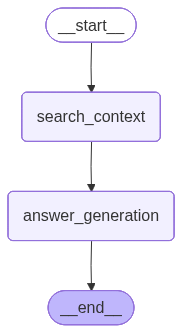

In [ ]:
graph

In [ ]:
user_query = "Technologies and also frameworks used by Atyantik"

In [ ]:
filter = models.Filter(
    must = [models.FieldCondition(
        key = "source",
        match = models.MatchValue(value = "https://atyantik.com/saas-development/")
    )])

In [ ]:
result = graph.invoke({"query": user_query,
                       "filter_conditions": filter
                       })

In [ ]:
result['answer']

'Atyantik has extensive experience with technologies like Laravel, NodeJS, and React.'

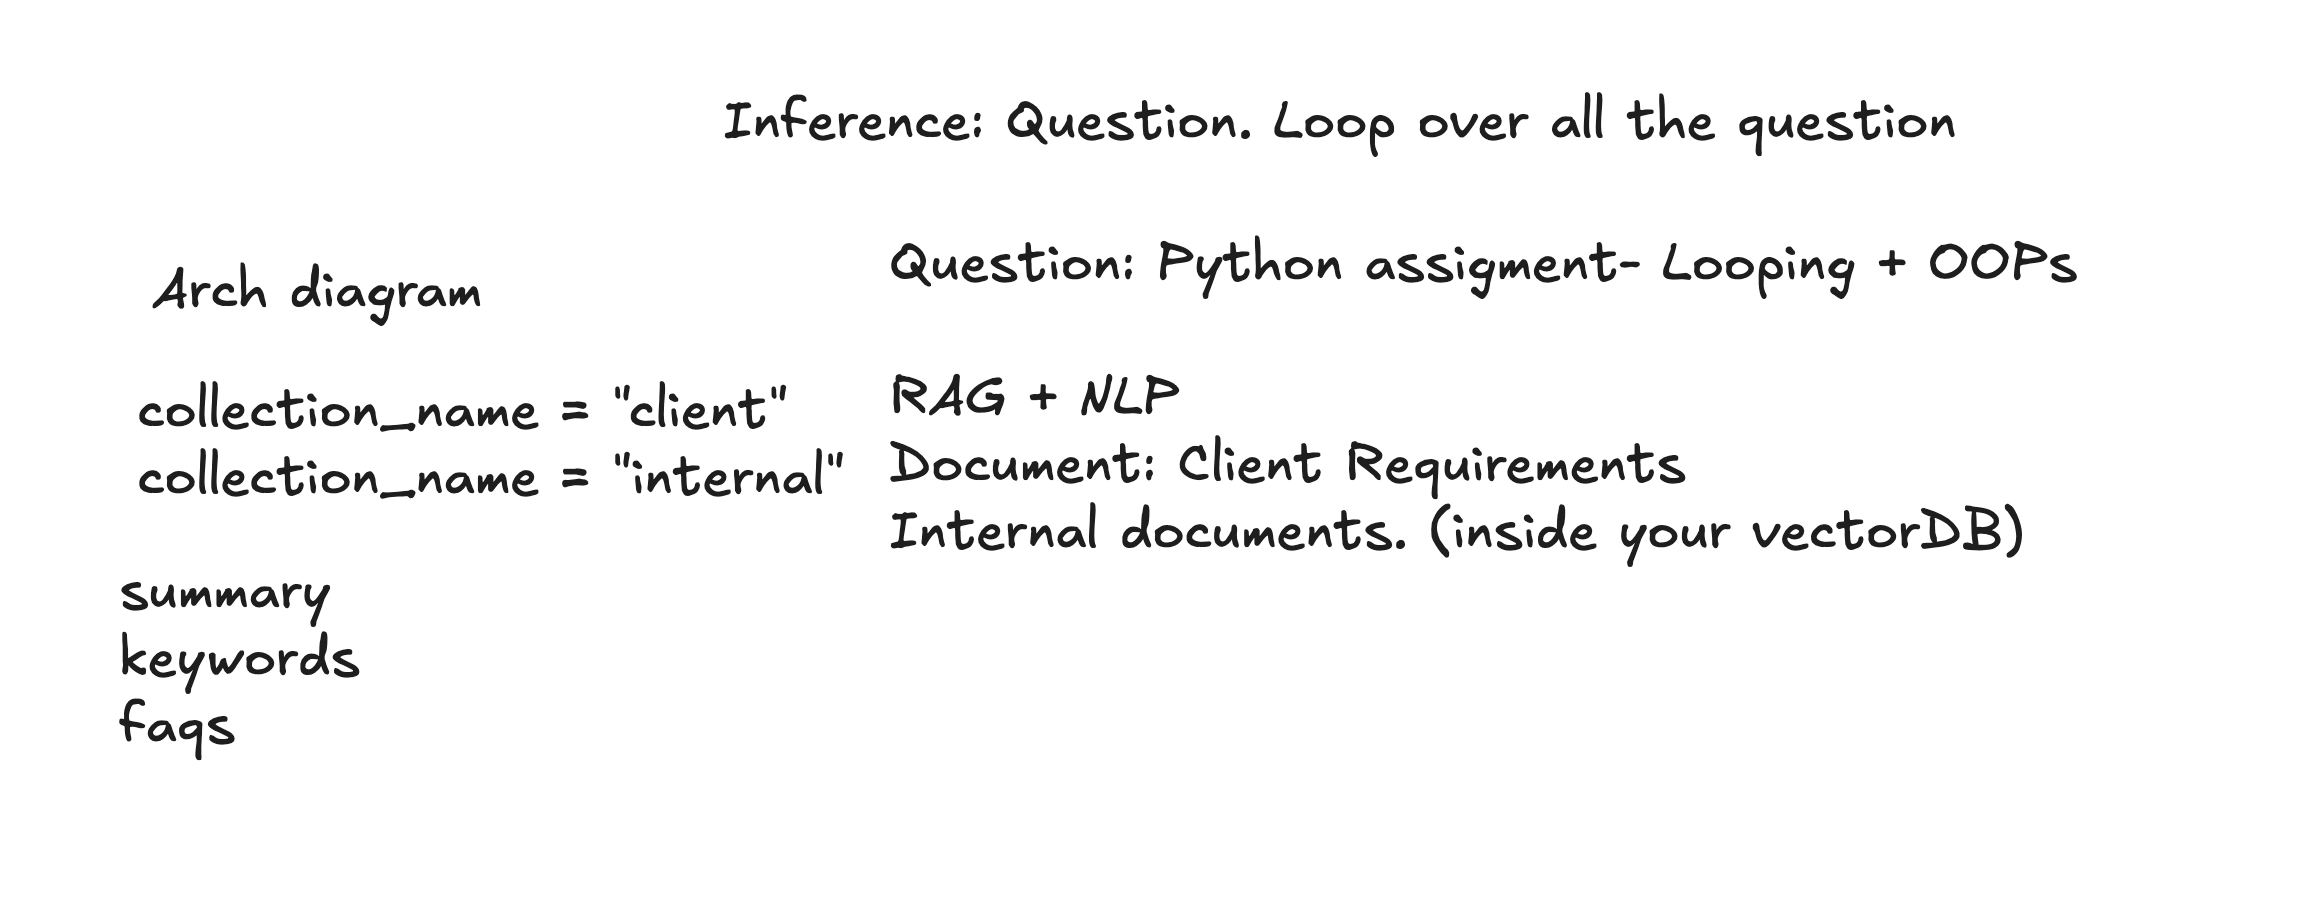